In [148]:
import sys
import numpy as np
import torch
import copy
import torch.nn as nn
import torch.distributed as dist
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader
import torch.multiprocessing as mp
import time
from requests import get
import os
import random
import math
import pickle
import argparse
import wandb
import gc
from tqdm import tqdm
from collections import defaultdict

In [149]:
def GenerateDataset_digit(p, q, ndig, nextra):

    assert 1 <= p <= ndig + nextra

    stoi = {'0': 0, '1': 1, '2': 2,'3': 3,'4': 4,'5': 5,'6': 6,'7': 7,'8': 8,'9': 9,'*': 10,'=': 11}

    data = []
    target = []

    k = 0
    while k < 200000:
        i = int(10**(p - 1 + torch.rand(size=(1,)).item()))
        j = int(10**(q - 1 + torch.rand(size=(1,)).item()))

        li = list(f'{i}')
        lj = list(f'{j}')
        lij = list(f'{i * j}')
        if len(li) < ndig+nextra:
            li = ['0'] * (ndig+nextra - len(li)) + li
        if len(lj) < ndig+nextra:
            lj = ['0'] * (ndig+nextra - len(lj)) + lj
        if len(lij) < 2*(ndig+nextra):
            lij = ['0'] * (2*(ndig+nextra) - len(lij)) + lij

        lsum = li + ['*'] + lj + lij
        lt = lsum[1:] + ['=']
        data.append([stoi[lsum[i]] for i in range(len(lsum))])
        target.append([stoi[lt[i]] for i in range(len(lt))])
        k += 1

    data = torch.LongTensor(data)
    target = torch.LongTensor(target)

    vocab = len(stoi)
    
    return vocab, data, target

def GenerateDataset_p(ndig, nextra, pad):

    stoi = {'0': 0, '1': 1, '2': 2,'3': 3,'4': 4,'5': 5,'6': 6,'7': 7,'8': 8,'9': 9,'*': 10,'=': 11, 'x': 12}

    data = []
    target = []
    data_f = []
    target_f = []

    k = 0
    while k < 500000:
        i = int(10**(ndig*torch.rand(size=(1,)).item()))
        j = int(10**(ndig*torch.rand(size=(1,)).item()))

        li = list(f'{i}')
        lj = list(f'{j}')
        lij = list(f'{i * j}')
        if len(li) < ndig+nextra+pad:
            li = ['x'] * (ndig+nextra+pad - len(li)) + li
        if len(lj) < ndig+nextra+pad:
            lj = ['x'] * (ndig+nextra+pad - len(lj)) + lj
        if len(lij) < 2*(ndig+nextra+pad):
            lij = ['x'] * (2*(ndig+nextra+pad) - len(lij)) + lij

        lsum = li + ['*'] + lj + lij
        lt = lsum[1:] + ['=']
        data.append([stoi[lsum[i]] for i in range(len(lsum))])
        target.append([stoi[lt[i]] for i in range(len(lt))])

        include = False
        while not include:
            i = int(10**(ndig+(nextra)*torch.rand(size=(1,)).item()))
            j = int(10**(ndig+(nextra)*torch.rand(size=(1,)).item()))
            include = (i * j < 10**(2*(ndig+nextra)))

        li = list(f'{i}')
        lj = list(f'{j}')
        lij = list(f'{i * j}')
        if len(li) < ndig+nextra+pad:
            li = ['x'] * (ndig+nextra+pad - len(li)) + li
        if len(lj) < ndig+nextra+pad:
            lj = ['x'] * (ndig+nextra+pad - len(lj)) + lj
        if len(lij) < 2*(ndig+nextra+pad):
            lij = ['x'] * (2*(ndig+nextra+pad) - len(lij)) + lij

        lsum = li + ['*'] + lj + lij
        lt = lsum[1:] + ['=']
        data_f.append([stoi[lsum[i]] for i in range(len(lsum))])
        target_f.append([stoi[lt[i]] for i in range(len(lt))])
        k += 1

    data_f = torch.LongTensor(data_f)
    target_f = torch.LongTensor(target_f)
    data = torch.LongTensor(data)
    target = torch.LongTensor(target)

    vocab = len(stoi)
    
    return vocab, data, target, data_f, target_f

def complexity(l0, l1):
    c = 0
    for i in range(len(l0)):
        for j in range(len(l1)):
            if int(l0[i]) * int(l1[j]) > 10:
                c += 1
    return c

def GenerateDataset_complexity(ndig, nextra, ex_per_class):

    stoi = {'0': 0, '1': 1, '2': 2,'3': 3,'4': 4,'5': 5,'6': 6,'7': 7,'8': 8,'9': 9,'*': 10,'=': 11}

    data = []
    target = []
    c = []
    data_f = []
    target_f = []
    c_f = []
    complexity_dict = defaultdict()
    k = 0
    done = False
    while not done:
        i = int(10**(ndig*torch.rand(size=(1,)).item()))
        j = int(10**(ndig*torch.rand(size=(1,)).item()))

        li = list(f'{i}')
        lj = list(f'{j}')
        lij = list(f'{i * j}')
        if len(li) < ndig+nextra:
            li = ['0'] * (ndig+nextra - len(li)) + li
        if len(lj) < ndig+nextra:
            lj = ['0'] * (ndig+nextra - len(lj)) + lj
        if len(lij) < 2*(ndig+nextra):
            lij = ['0'] * (2*(ndig+nextra) - len(lij)) + lij
        
        c0 = complexity(li, lj)
        
        if c0 not in complexity_dict:
            complexity_dict[c0] = 0
        
        if complexity_dict[c0] < ex_per_class:

            lsum = li + ['*'] + lj + lij
            lt = lsum[1:] + ['=']
            data.append([stoi[lsum[i]] for i in range(len(lsum))])
            target.append([stoi[lt[i]] for i in range(len(lt))])
            c.append(c0)

            complexity_dict[c0] += 1
        
        elif all((complexity_dict[i] >= ex_per_class) for i in range(10)):
            done = True

        else:
            continue
        
        # if all((complexity_dict[i] >= 100) for i in range(10)):
        #     done = True

        include = False
        while not include:
            i = int(10**(ndig+(nextra)*torch.rand(size=(1,)).item()))
            j = int(10**(ndig+(nextra)*torch.rand(size=(1,)).item()))
            include = (i * j < 10**(2*(ndig+nextra)))

        li = list(f'{i}')
        lj = list(f'{j}')
        lij = list(f'{i * j}')
        if len(li) < ndig+nextra:
            li = ['0'] * (ndig+nextra - len(li)) + li
        if len(lj) < ndig+nextra:
            lj = ['0'] * (ndig+nextra - len(lj)) + lj
        if len(lij) < 2*(ndig+nextra):
            lij = ['0'] * (2*(ndig+nextra) - len(lij)) + lij

        c1 = complexity(li, lj)

        lsum = li + ['*'] + lj + lij
        lt = lsum[1:] + ['=']
        data_f.append([stoi[lsum[i]] for i in range(len(lsum))])
        target_f.append([stoi[lt[i]] for i in range(len(lt))])
        c_f.append(c1)

    data_f = torch.LongTensor(data_f)
    target_f = torch.LongTensor(target_f)
    data = torch.LongTensor(data)
    target = torch.LongTensor(target)

    vocab = len(stoi)
    
    return vocab, data, target, c, data_f, target_f, c_f, complexity_dict

In [151]:
class DecoderTot(nn.Module):

  def __init__(self, decoder, embed, generator):
    super().__init__()
    self.embed = embed
    self.gen = generator
    self.decoder = decoder
    self.generator = generator

  def forward(self, src, mask):
    return self.generator(self.decoder(self.embed(src), mask))


class Generator(nn.Module):

  def __init__(self, d_model, vocab_size):
    super().__init__()
    self.ln = nn.Linear(d_model, vocab_size)

  def forward(self, x):
    return F.log_softmax(self.ln(x), dim=-1)

class Decoder(nn.Module):

    def __init__(self, attn, ffn, d_model, dropout):
        super().__init__()
        self.attn = attn
        self.ffn = ffn
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.d_model = d_model
        self.out = None

    def forward(self, x, mask):

        x1 = self.norm(x)
        x = x + self.dropout(self.attn(x1, x1, x1, mask))
        self.out = x + self.dropout(self.ffn(self.norm(x)))
        return self.out

class DecoderStack(nn.Module):

    def __init__(self, layer, N):
        super().__init__()
        self.N = N
        self.norm = nn.LayerNorm(layer.d_model)
        self.layers = nn.ModuleList([copy.deepcopy(layer) for _ in range(N)])

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

def Attention(q, k, v, theta, mask=None, dropout=None):

            ### -- Softmax Attention with RoFormer -- ###

            # q, k, v are dims (batch_size, # heads, seq_len, d_{k,v})

            m = torch.arange(k.shape[-2]).view(k.shape[-2], 1).to(q.device)
            t = torch.arange(k.shape[-1]).view(1, k.shape[-1])
            t = torch.exp( - ( 2 * np.log(theta) / k.shape[-1] ) * torch.floor(t/2.) ).to(q.device)
            r1 = torch.cos(m * t)
            r2 = torch.sin(m * t)

            K = torch.cat((q, k, v))

            Kp = torch.einsum('ijkl, kl -> ijkl', K, r1)

            L = torch.kron(torch.eye(k.shape[-1]//2), torch.Tensor([[0,-1],[1,0]])).to(q.device)
            K = torch.einsum('ijkl, ml -> ijkm', K, L)

            Kp += torch.einsum('ijkl, kl -> ijkl', K, r2)

            Kp = Kp.view(-1, k.shape[0], k.shape[1], k.shape[2], k.shape[-1])

            q, k, v = Kp[0], Kp[1], v # Kp[2]

            A = torch.matmul(q, k.transpose(-2,-1)) * k.size(-1)**(-0.5)

            if mask is not None:
                A.masked_fill_(mask == 0, float('-inf'))

            O = F.softmax(A, dim=-1)

            if dropout is not None:
                O = dropout(O)

            return torch.matmul(O, v), O


class MultiHeadedAttention(nn.Module):

    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        self.d_k = d_model // h
        self.h = h
        self.attn = None
        self.linears = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(4)])
        self.dropout =  nn.Dropout(p=dropout)
        self.theta = 10.0

    def forward(self, query, keys, values, mask=None):

        batch_size = query.shape[0]

        x = [l(z).view(batch_size, -1, self.h, self.d_k).transpose(1, 2) for l, z in zip(self.linears, (query, keys, values))]

        y, self.attn = Attention(x[0], x[1], x[2], self.theta, mask=mask, dropout=self.dropout)

        y = y.transpose(1,2).contiguous().view(batch_size, -1, self.h * self.d_k)

        return self.linears[-1](y)

class FeedForward(nn.Module):

    def __init__(self, d_model, d_ff, dropout):
        super().__init__()
        self.w1 = nn.Linear(d_model, d_ff)
        self.w2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.out = None
        self.out_p = None

    def forward(self, x):
        self.out = self.relu(self.w1(x))
        self.out_p = self.w2(self.dropout(self.out))
        return self.w2(self.dropout(self.out))

class Embeddings(nn.Module):

    def __init__(self, src_vocab, d_model):
        super().__init__()
        self.Emb = nn.Embedding(src_vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.Emb(x) * np.sqrt(self.d_model)

def make_model(vocab, N = 6, d_model = 512, d_ff = 2048, h = 8, dropout = 0.1):

    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ffn = FeedForward(d_model, d_ff, dropout)

    model = DecoderTot(DecoderStack(Decoder( c(attn), c(ffn), d_model, dropout), N),
                           Embeddings(vocab, d_model),  Generator(d_model, vocab))

    for p in model.parameters():
        if p.dim() > 1: # This is there to not initialize the biases
            nn.init.xavier_uniform_(p)
    # print('# of parameters =', sum(p.nelement() for p in model.parameters())) # number of parameters in total

    return model

def GenerateDataset(ndig, nextra):

    stoi = {'0': 0, '1': 1, '2': 2,'3': 3,'4': 4,'5': 5,'6': 6,'7': 7,'8': 8,'9': 9,'*': 10,'=': 11}

    data = []
    target = []
    data_f = []
    target_f = []

    k = 0
    while k < 200000:
        i = int(10**(ndig*torch.rand(size=(1,)).item()))
        j = int(10**(ndig*torch.rand(size=(1,)).item()))

        li = list(f'{i}')
        lj = list(f'{j}')
        lij = list(f'{i * j}')
        if len(li) < ndig+nextra:
            li = ['0'] * (ndig+nextra - len(li)) + li
        if len(lj) < ndig+nextra:
            lj = ['0'] * (ndig+nextra - len(lj)) + lj
        if len(lij) < 2*(ndig+nextra):
            lij = ['0'] * (2*(ndig+nextra) - len(lij)) + lij

        lsum = li + ['*'] + lj + lij
        lt = lsum[1:] + ['=']
        data.append([stoi[lsum[i]] for i in range(len(lsum))])
        target.append([stoi[lt[i]] for i in range(len(lt))])

        include = False
        while not include:
            i = int(10**(ndig+(nextra)*torch.rand(size=(1,)).item()))
            j = int(10**(ndig+(nextra)*torch.rand(size=(1,)).item()))
            include = (i * j < 10**(2*(ndig+nextra)))

        li = list(f'{i}')
        lj = list(f'{j}')
        lij = list(f'{i * j}')
        if len(li) < ndig+nextra:
            li = ['0'] * (ndig+nextra - len(li)) + li
        if len(lj) < ndig+nextra:
            lj = ['0'] * (ndig+nextra - len(lj)) + lj
        if len(lij) < 2*(ndig+nextra):
            lij = ['0'] * (2*(ndig+nextra) - len(lij)) + lij

        lsum = li + ['*'] + lj + lij
        lt = lsum[1:] + ['=']
        data_f.append([stoi[lsum[i]] for i in range(len(lsum))])
        target_f.append([stoi[lt[i]] for i in range(len(lt))])
        k += 1

    data_f = torch.LongTensor(data_f)
    target_f = torch.LongTensor(target_f)
    data = torch.LongTensor(data)
    target = torch.LongTensor(target)

    vocab = len(stoi)
    
    return vocab, data, target, data_f, target_f

class Dataset(torch.utils.data.Dataset):

    def __init__(self, inputs, target):
        self.inputs = inputs
        self.target = target

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        src = self.inputs[index]
        tgt = self.target[index]

        return src, tgt

def prepare(rank, world_size, data, target, batch_size, pin_memory=True, num_workers=0):

    dataset = Dataset(data, target)
    # sampler = DistributedSampler(dataset, num_replicas=world_size, rank=rank, shuffle=False, drop_last=False)

    # dataloader = DataLoader(dataset, batch_size=batch_size, pin_memory=pin_memory, num_workers=num_workers, drop_last=False, shuffle=False, sampler=sampler)
    dataloader = DataLoader(dataset, batch_size=batch_size, pin_memory=pin_memory, num_workers=num_workers, drop_last=False, shuffle=False)
    return dataloader

def cleanup():
    dist.destroy_process_group()

def accuracy_calc(model, inputs, targets, gen_length, pad_token):

    acc = []

    max_gen = 0

    while max_gen < gen_length:
        seq_len = inputs.shape[-1]
        mask = torch.tril(torch.ones(seq_len, seq_len)).to('cuda:0')

        out = model(inputs, mask)[:, -1]
        next_tok = torch.argmax(out, -1)

        max_gen += 1
        inputs = torch.cat((inputs, next_tok.unsqueeze(1)), 1)

        if (max_gen == gen_length):
            for i in range(inputs.shape[0]):
                in_z = inputs[i, -max_gen:][inputs[i, -max_gen:] != pad_token]
                target_z = targets[i, -max_gen:][targets[i, -max_gen:] != pad_token]
                try:
                    acc_z = (in_z == target_z).float().min().item()

                    acc.append(acc_z)
                except:
                    continue
    return sum(acc) / len(acc) if len(acc) > 0 else 0.0

def run_epoch(data, loader, model, optimizer, scheduler, device, args, status='train'):

    for i, batch in enumerate(loader):

        src, tgt = batch[0].to(device), batch[1].to(device)

        num_digits = args.ndigits + args.nextra
        seq_len = src.shape[-1]
        mask = torch.tril(torch.ones(seq_len, seq_len)).to(src.device)
        logits = model.forward(src, mask)[:, -(2*num_digits + 1):]
        tgt = tgt[:, -(2*num_digits + 1):]

        kl_loss = nn.CrossEntropyLoss()

        loss = kl_loss(logits.transpose(-1, -2), tgt) # We want inputs to be (bs, vocab_size, seq len), so needed a transpose. Targets are (bs, seq len) with values in [0, vocab_size]

        a = (torch.argmax(logits.detach(), dim=-1) == tgt).float()

        acc_p = sum((torch.argmax(logits.detach(), dim=-1)[i] == tgt[i]).float().min() for i in range(len(tgt))) / len(tgt)

        a = a.mean(dim=0).tolist()
        a.append(acc_p)
        a.append(loss.detach().item())

        if status == 'train':
            if i % 100 == 0:
                print(f' {status} loss = {loss.item()}')
                print(f' {status} acc. = {acc_p.item()}')
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()
            scheduler.step()

        if status == 'eval':
            if i % 100 == 0:
                print(f' {status} loss = {loss.item()}')
                print(f' {status} acc. = {acc_p.item()}')
            w2 = sum((p.data**2).sum() for p in model.parameters()).clone().detach().to('cpu')
            a.append(w2.item())
        
        pre_data = torch.tensor(a) # accuracy per token, correctness, loss
        data = torch.cat((data, pre_data.unsqueeze(0)), 0)

        del loss, tgt, src, logits

    return data

def train(args):

    ### Dataset

    print('--- Generating data ---')
    vocab, data, target, data_f, target_f = GenerateDataset_complexity(ndig=args.ndigits, nextra = args.nextra, ex_per_class=50000)
    print('--- Finished generating data ---')
    # Three way split (training, test)
    random.seed()
    z = list(zip(data.tolist(), target.tolist()))
    random.shuffle(z)

    z1, z2 = zip(*z)
    src_array_sh, tgt_array_sh = torch.LongTensor(list(z1)), torch.LongTensor(list(z2))

    rank = torch.device('cuda:0')
    world_size = 0

    # Dataset parameters

    batch_size = args.batch_size
    batch_size_eval = args.batch_size_eval

    vocab = vocab

    split = args.split

    n1 = int(split*len(src_array_sh))
    n2 = 2*n1
    # n1 = 0
    # n0 = 100
    priming_examples = 0

    src_train, src_test = src_array_sh[:n1], src_array_sh[n1:n2]
    tgt_train, tgt_test = tgt_array_sh[:n1], tgt_array_sh[n1:n2]
    src_long, tgt_long = data_f[:priming_examples], target_f[:priming_examples]
    src_test_long, tgt_test_long = data_f[priming_examples:], target_f[priming_examples:]

    # src_train = torch.cat((src_train, src_long), 0)
    # tgt_train = torch.cat((tgt_train, tgt_long), 0)
    # src_train = src_long
    # tgt_train = tgt_long

    random.seed()
    z = list(zip(src_train.tolist(), tgt_train.tolist()))
    random.shuffle(z)

    z1, z2 = zip(*z)
    src_train, tgt_train = torch.LongTensor(list(z1)), torch.LongTensor(list(z2))

    dataloader_train = prepare(rank, world_size, src_train, tgt_train, batch_size)

    dataloader_test = prepare(rank, world_size, src_test, tgt_test, batch_size_eval)

    dataloader_test_long = prepare(rank, world_size, src_test_long, tgt_test_long, batch_size_eval)

    ### Model

    d_model = args.d_model
    d_ff = args.d_ff
    n_heads = args.heads
    n_layers = args.num_layers

    model = make_model(vocab, N = n_layers, d_model = d_model, d_ff = d_ff, h = n_heads, dropout = 0.1)

    model = model.to(rank)

    ### Training parameters and optimizer

    lr = args.learning_rate
    weight_decay = args.weight_decay    
    num_epochs = args.epochs

    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr = lr,
                                  betas = (0.9, 0.98),
                                  eps=1e-8,
                                  weight_decay=weight_decay)
    
    def NoamLR(step, warmup, model_size):
        return model_size ** -0.5 * min(step ** -0.5, step * warmup ** -1.5)
    
    lr_scheduler = LambdaLR(optimizer=optimizer, lr_lambda = lambda step: NoamLR(step, warmup=1000, model_size=args.d_model))

    ### Tracking

    theta = model.decoder.layers[0].attn.theta

    wandb.init(project="Generative Multiplication",
                     config={"lr": lr,
                             "split":split,
                             "layers": n_layers,
                             "weight decay": weight_decay,
                             "d_ff": d_ff,
                             "d_model": d_model,
                             "heads": n_heads,
                             "theta": theta,
                             "Priming examples": priming_examples,
                             "n digits train": args.ndigits,
                             "n digits test": f'{args.ndigits} + {args.nextra}',
                             "batch size": batch_size,
                             "batch_size_eval": batch_size_eval,
                             'random padding': False,
                             'padding': args.pad,
                             'ID': args.ID,
                             'Comment': 'Uniform in difficulty'
                             }
                        )

    ### Training    

    for epoch in range(num_epochs):
        print(f' --- {epoch} ---')
        data = torch.tensor([])
        data_t = torch.tensor([])
        data_tl = torch.tensor([])

        model.train()
        data = run_epoch(data, loader=dataloader_train, model=model, optimizer=optimizer, scheduler=lr_scheduler, device=rank, args=args, status='train')
        
        data = data.mean(dim=0)
        s = {}
        s['training loss'] = data[-1]
        z = [f'training acc. pos {i}' for i in range(args.ndigits + args.nextra + 1)]
        for i in range(len(z)):
            s[z[i]] = data[i]
        s['training acc.'] = data[-2]
        wandb.log(s,
            step=epoch
            )

        model.eval()
        with torch.no_grad():
            data_t = run_epoch(data_t, loader=dataloader_test, model=model, optimizer=optimizer, scheduler=lr_scheduler, device=rank, args=args, status='eval')

            data_tl = run_epoch(data_tl, loader=dataloader_test_long, model=model, optimizer=optimizer, scheduler=lr_scheduler, device=rank, args=args, status='eval')

        data = data_t.mean(dim=0)
        data_long = data_tl.mean(dim=0)

        s = {}
        s['test loss'] = data[-2]
        z = [f'test acc. pos {i}' for i in range(2*(args.ndigits + args.nextra) + 1)]
        for i in range(len(z)):
            s[z[i]] = data[i]
        s['test acc.'] = data[-3]
        s['norm weights squared'] = data[-1]

        s['test loss long'] = data_long[-2]
        z = [f'test acc. pos {i} long' for i in range(2*(args.ndigits + args.nextra) + 1)]
        for i in range(len(z)):
            s[z[i]] = data_long[i]
        s['test acc. long'] = data_long[-3]
        wandb.log(s,
            step=epoch
            )

        if epoch % 50 == 0:
            outputFile = args.output_dir + '/model_n{!s}_s{!s}_w{!s}_epoch{!s}'.format(n_layers, split, weight_decay, epoch)

            torch.save({
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                    }, outputFile)

    # cleanup()
    wandb.finish()

    outputFile = args.output_dir + '/model_n{!s}_s{!s}_w{!s}_{!s}_final'.format(n_layers, split, weight_decay, args.ID)

    torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict()
            }, outputFile)
    return model

In [152]:
parser = argparse.ArgumentParser()

parser.add_argument("--split", default=0.3, type=float)
parser.add_argument("--weight_decay", default=0.3, type=float)
parser.add_argument("--num_layers", default=6, type=int)
parser.add_argument("--d_model", default=512, type=int)
parser.add_argument("--d_ff", default=2048, type=int)
parser.add_argument("--heads", default=8, type=int)
parser.add_argument("--epochs", default=40, type=int)
parser.add_argument("--batch_size", default=32, type=int)
parser.add_argument("--batch_size_eval", default=512, type=int)
parser.add_argument("--learning_rate", default=1e-5, type=float)
parser.add_argument("--ndigits", default=3, type=int)
parser.add_argument("--nextra", default=3, type=int)
parser.add_argument("--pad", default=0, type=int)
parser.add_argument("--output_dir", default="multiplication_generative/", type=str)
parser.add_argument("--ID", default=13, type=int)

args = parser.parse_args(args=[])

model = train(args)

--- Generating data ---


ValueError: too many values to unpack (expected 5)

In [24]:
vocab, data, target, data_f, target_f = GenerateDataset(3, 3)

In [30]:
output_file = 'multiplication_generative/model_n6_s0.3_w0.3_12_final'
n_layer = 6 # number of layers
d_model = 512 # model dimension, residual stream
d_ff = 2048 # dim intermediate feed-forward layer
h_a = 8 # number of heads in attention (doesnt impact # of params)

model = make_model(vocab=12, N = n_layer, d_model = d_model, d_ff = d_ff, h = h_a)

model.load_state_dict(torch.load(output_file)['model'])

model = model.to('cuda:0')
model.eval()

DecoderTot(
  (embed): Embeddings(
    (Emb): Embedding(12, 512)
  )
  (gen): Generator(
    (ln): Linear(in_features=512, out_features=12, bias=True)
  )
  (decoder): DecoderStack(
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-5): 6 x Decoder(
        (attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-3): 4 x Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ffn): FeedForward(
          (w1): Linear(in_features=512, out_features=2048, bias=True)
          (w2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (relu): ReLU()
        )
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (generator): Generator(
    (ln): Linear(in_features=512, out_features=12, bias=True)
 

In [47]:
def acc_mult(p, q):

    _, data, target = GenerateDataset_digit(p, q, 3, 3)

    acc = 0
    ntot = 2*6
    for j in range(50):

        num_ex = 200
        data_ff = data[j*num_ex:(j+1)*num_ex, :ntot + 1].to('cuda:0')

        u = 0
        inputs = data_ff
        target_ff = target[j*num_ex:(j+1)*num_ex].to('cuda:0')
        max_gen = 0

        while max_gen < ntot + 1:
            seq_len = inputs.shape[-1]
            mask = torch.tril(torch.ones(seq_len, seq_len)).to('cuda:0')

            out = model(inputs, mask)[:, -1]
            next_tok = torch.argmax(out, -1)

            u = next_tok
            max_gen += 1
            inputs = torch.cat((inputs, next_tok.unsqueeze(1)), 1)

            if (max_gen == ntot + 1):

                acc += sum((inputs[i, -(ntot+1):] == target_ff[i, -(ntot+1):]).float().min() for i in range(len(inputs))) / len(inputs)
    return acc.detach().item() / 50

In [48]:
acc = []
for p in tqdm(range(1, 6)):
    acc_l = []
    for q in range(1, 6):
        accp = acc_mult(p, q)
        acc_l.append(accp)
    acc.append(acc_l)

100%|██████████| 5/5 [08:55<00:00, 107.10s/it]


In [50]:
import matplotlib.pyplot as plt

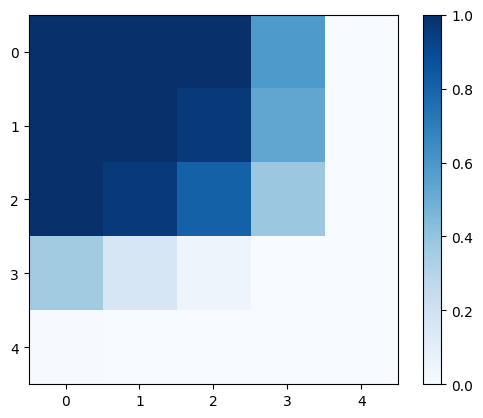

In [53]:
plt.imshow(acc, cmap='Blues')
plt.colorbar()

In [54]:
acc

[[1.0, 1.0, 0.9998999786376953, 0.5897000503540039, 0.00029999999329447744],
 [1.0,
  0.9974000549316406,
  0.9606000518798828,
  0.532400016784668,
  0.000599999949336052],
 [0.9999000549316406,
  0.9572999572753906,
  0.8122000122070312,
  0.38150001525878907,
  0.0004999999701976776],
 [0.36189998626708986,
  0.15770000457763672,
  0.047699990272521975,
  0.0007999999076128006,
  0.0],
 [0.0042999997735023495, 0.00039999999105930326, 0.0, 0.0, 0.0]]

In [50]:
import matplotlib.pyplot as plt

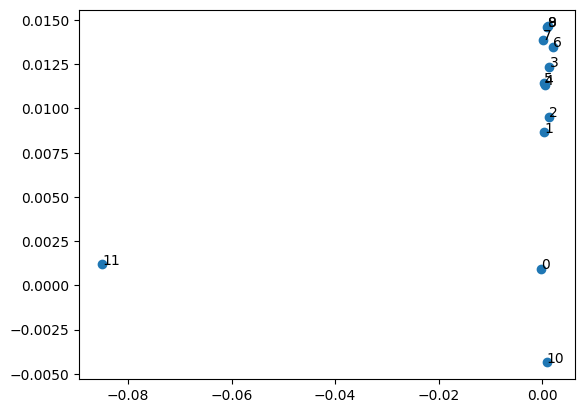

In [51]:
emb = model.embed.Emb.weight.data.detach().cpu()

svdEMB = torch.svd(emb)

a, b = 0, 1

x = svdEMB[0][:, a] * svdEMB[1][a]
y = svdEMB[0][:, b] * svdEMB[1][b]

plt.scatter(x, y)

i = 0
for x, y in zip(x, y):
    plt.annotate(f'{i}', (x, y))
    i += 1

In [52]:
att = [model.decoder.layers[i].attn.attn.detach().to('cpu').mean(dim=0) for i in range(6)]

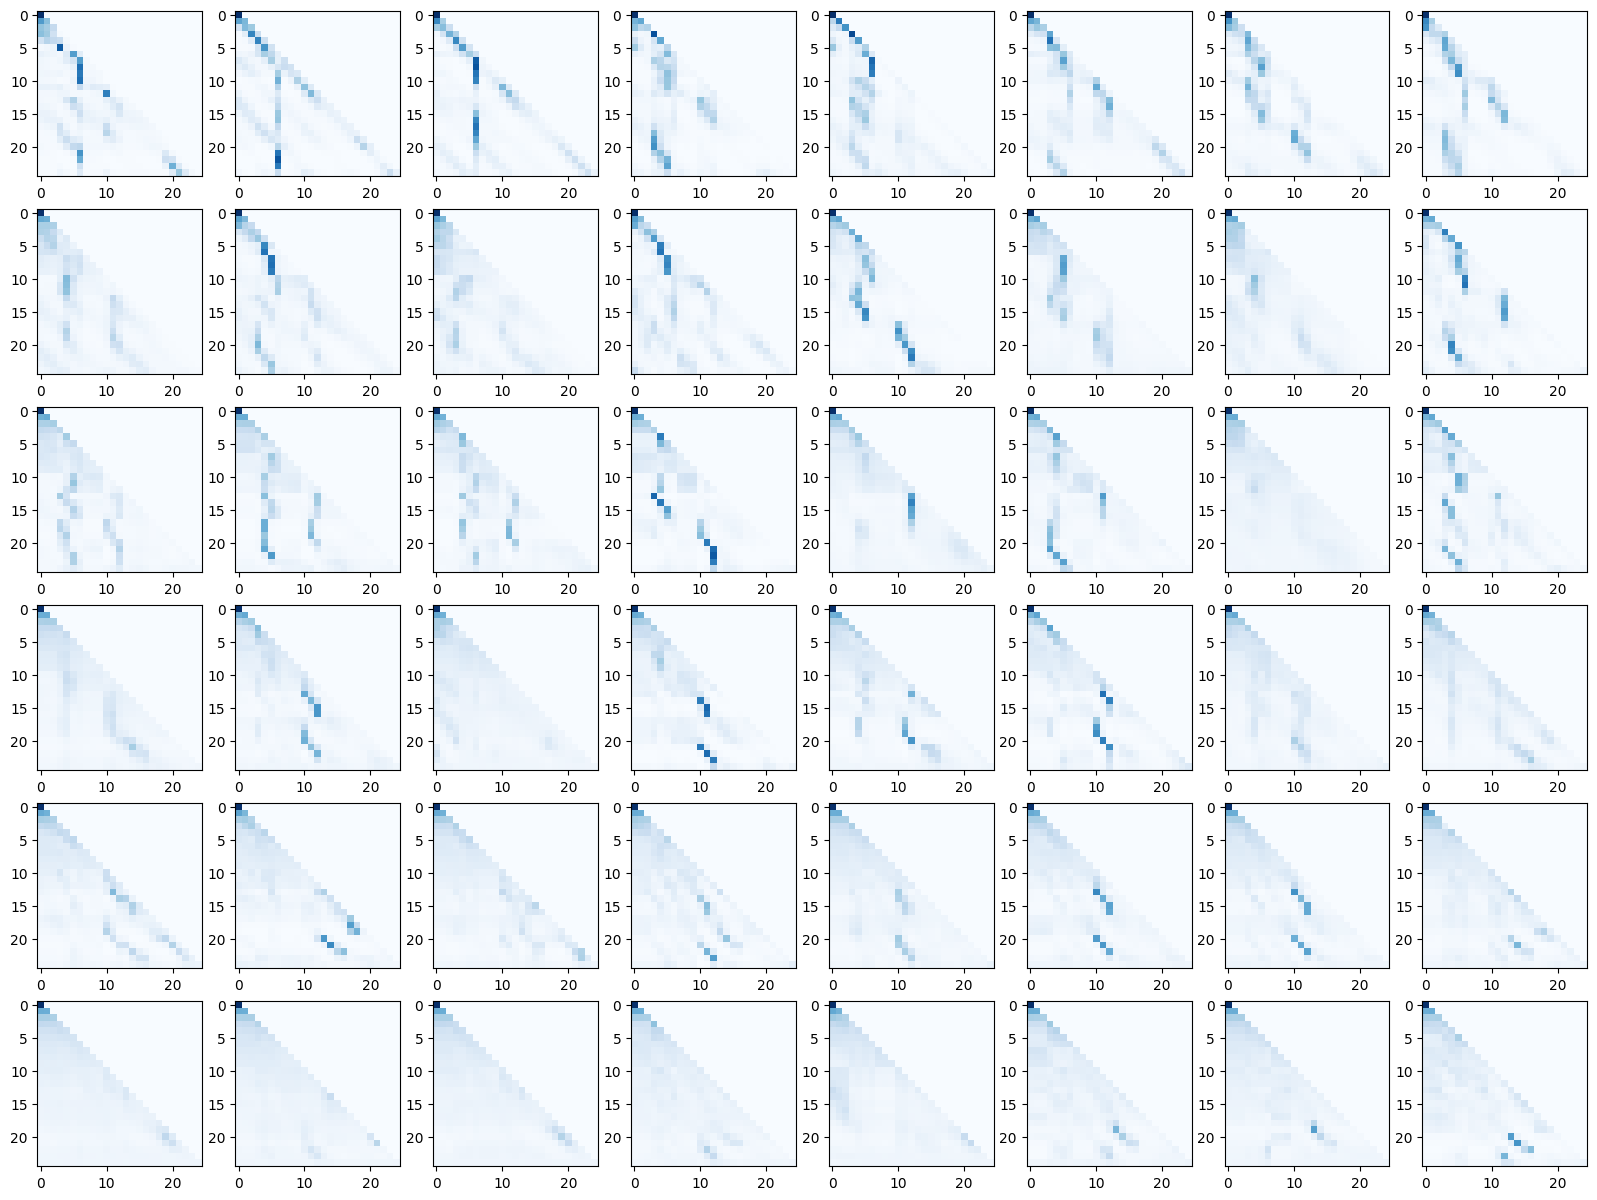

In [53]:
fig, ax = plt.subplots(6, 8, figsize=(20, 15))

for i in range(6):
    for j in range(8):
        ax[i, j].imshow(att[i][j], cmap='Blues')

In [158]:
from collections import defaultdict

In [174]:
def complexity(l0, l1):
    c = 0
    for i in range(len(l0)):
        for j in range(len(l1)):
            if int(l0[i]) * int(l1[j]) > 10:
                c += 1
    return c


def GenerateDataset_complexity(ndig, nextra, ex_per_class):

    stoi = {'0': 0, '1': 1, '2': 2,'3': 3,'4': 4,'5': 5,'6': 6,'7': 7,'8': 8,'9': 9,'*': 10,'=': 11}

    data = []
    target = []
    c = []
    data_f = []
    target_f = []
    c_f = []
    complexity_dict = defaultdict()
    k = 0
    done = False
    while not done:
        i = int(10**(ndig*torch.rand(size=(1,)).item()))
        j = int(10**(ndig*torch.rand(size=(1,)).item()))

        li = list(f'{i}')
        lj = list(f'{j}')
        lij = list(f'{i * j}')
        if len(li) < ndig+nextra:
            li = ['0'] * (ndig+nextra - len(li)) + li
        if len(lj) < ndig+nextra:
            lj = ['0'] * (ndig+nextra - len(lj)) + lj
        if len(lij) < 2*(ndig+nextra):
            lij = ['0'] * (2*(ndig+nextra) - len(lij)) + lij
        
        c0 = complexity(li, lj)
        
        if c0 not in complexity_dict:
            complexity_dict[c0] = 0
        
        if complexity_dict[c0] < ex_per_class:

            lsum = li + ['*'] + lj + lij
            lt = lsum[1:] + ['=']
            data.append([stoi[lsum[i]] for i in range(len(lsum))])
            target.append([stoi[lt[i]] for i in range(len(lt))])
            c.append(c0)

            complexity_dict[c0] += 1
            s = sum(complexity_dict[q] for q in complexity_dict.keys())
        else:
            if s >= 10*ex_per_class:
                done = True
            else:
                continue
        
        # if all((complexity_dict[i] >= 100) for i in range(10)):
        #     done = True

        include = False
        while not include:
            i = int(10**(ndig+(nextra)*torch.rand(size=(1,)).item()))
            j = int(10**(ndig+(nextra)*torch.rand(size=(1,)).item()))
            include = (i * j < 10**(2*(ndig+nextra)))

        li = list(f'{i}')
        lj = list(f'{j}')
        lij = list(f'{i * j}')
        if len(li) < ndig+nextra:
            li = ['0'] * (ndig+nextra - len(li)) + li
        if len(lj) < ndig+nextra:
            lj = ['0'] * (ndig+nextra - len(lj)) + lj
        if len(lij) < 2*(ndig+nextra):
            lij = ['0'] * (2*(ndig+nextra) - len(lij)) + lij

        c1 = complexity(li, lj)

        lsum = li + ['*'] + lj + lij
        lt = lsum[1:] + ['=']
        data_f.append([stoi[lsum[i]] for i in range(len(lsum))])
        target_f.append([stoi[lt[i]] for i in range(len(lt))])
        c_f.append(c1)

    data_f = torch.LongTensor(data_f)
    target_f = torch.LongTensor(target_f)
    data = torch.LongTensor(data)
    target = torch.LongTensor(target)

    vocab = len(stoi)
    
    return vocab, data, target, c, data_f, target_f, c_f, complexity_dict

In [175]:
vocab, data, target, c, data_f, target_f, c_f, c_dict = GenerateDataset_complexity(3, 3, 500)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


(array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

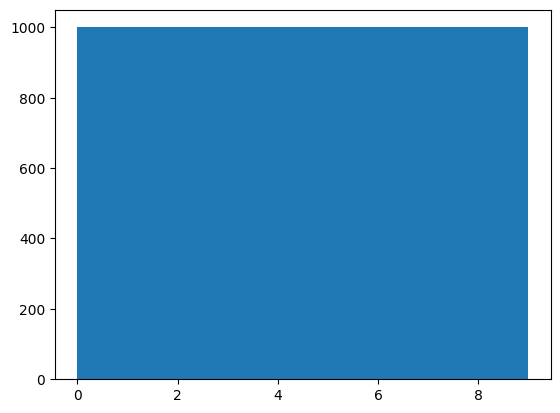

In [142]:
plt.hist(c, bins=10)

(array([ 2273.,  1810.,  5872.,  9203., 16220., 15364., 28055., 20723.,
        36255., 31742., 35078., 27030., 46329., 22459., 28367., 30788.,
        28640., 14637., 20355., 12805., 20010.,  6961.,  7824.,  6751.,
         7926.,  5009.,  2276.,  1937.,  2215.,  1323.,  2315.,   206.,
          299.,   277.,   255.,   411.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36.]),
 <BarContainer object of 36 artists>)

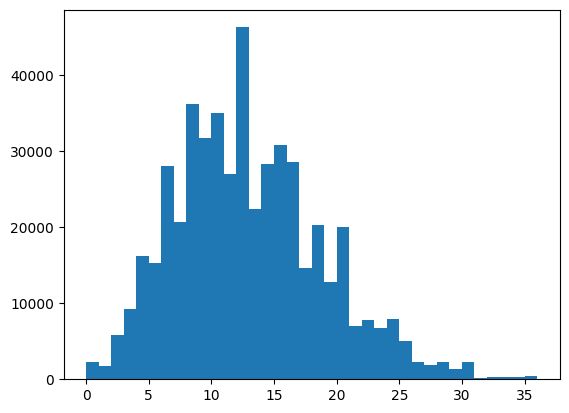

In [80]:
plt.hist(c_f, bins=36)